Deutsch-Jozsa Algorithm

In [1]:
# initialization
import numpy as np

# importing Qiskit
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer.primitives import Estimator
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp

# import basic plot tools
from qiskit.visualization import plot_histogram

In [2]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input, plus one output qubit
    oracle_qc = QuantumCircuit(n+1)

    # First, let's deal with the case in which the oracle is balanced
    if case == "balanced":
        # We apply controlled-NOT gates for each qubit, using the output qubit as the target
        for qubit in range(n):
            oracle_qc.cx(qubit, n)

    # Next, let's deal with the case in which the oracle is constant
    if case == "constant":
        # First decide what the fixed output o the oracle will be (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)

    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    
    return oracle_gate

In [3]:
def dj_algorithm(n, case = "random"):
    dj_circuit = QuantumCircuit(n+1, n)
    
    # Set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    # And set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    
    # Let's append the oracle gate to our circuit:
    if case == "random":
        random = np.random.randint(2)
        if random == 0:
            case = "constant"
        else:
            case = "balanced"

    oracle = dj_oracle(case, n)
    dj_circuit.append(oracle, range(n+1))

    # Finally, perform the Hadamard gates again and measure:
    for i in range(n):
        dj_circuit.h(i)
        dj_circuit.measure(i,i)

    return dj_circuit

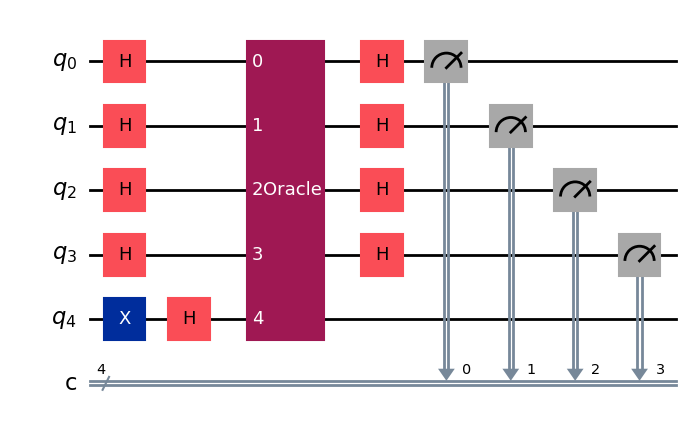

In [4]:
n = 4
#dj_circuit = dj_algorithm(n, "random")
dj_circuit = dj_algorithm(n, "balanced")
#dj_circuit = dj_algorithm(n, "constant")
dj_circuit.draw("mpl")

In [5]:
# Use a local fake backend
backend = FakeManilaV2()

# Circuits must obey the Instruction Set Architecture (ISA) of the backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(dj_circuit)

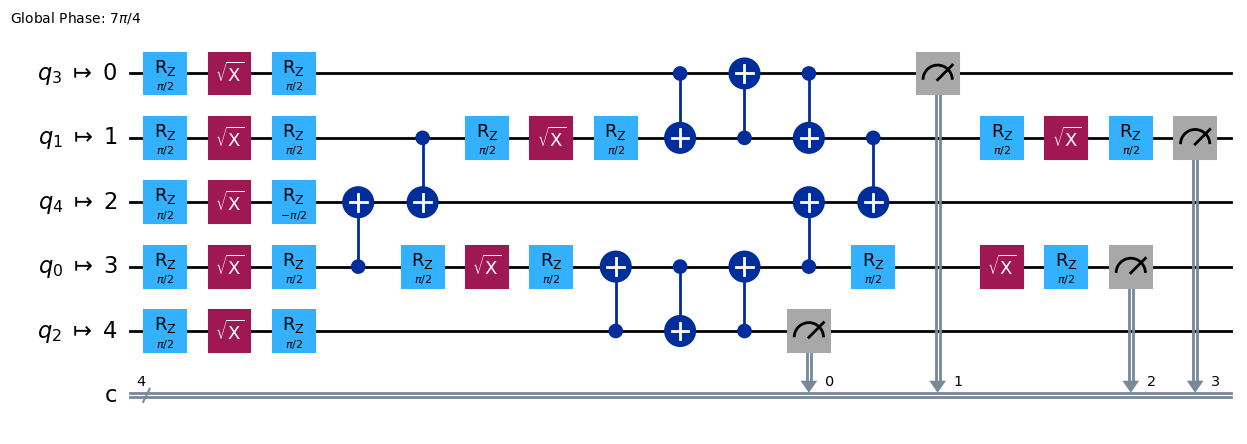

In [6]:
isa_circuit.draw("mpl")

In [7]:
estimator = Estimator()
observable = SparsePauliOp("IIIIZ")
result = estimator.run(isa_circuit, observable, shots=2048).result()
result.values

array([-1.])

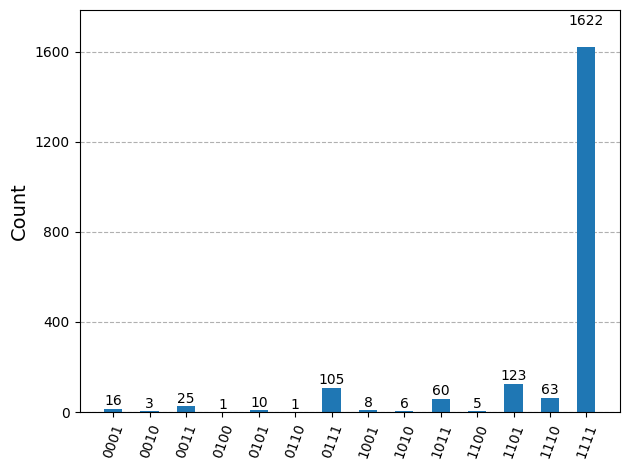

In [8]:
sampler = Sampler(mode=backend)
result = sampler.run([isa_circuit], shots=2048).result()
counts = result[0].data.c.get_counts()
plot_histogram(counts)